# Traffic Sign Recognition

## Dependencies

In [1]:
from numpy.random import seed
seed(86148)

import sys
sys.path.append('./lib') # For personal extra modules

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import regularizers 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

#EXTRAS
from cutout import get_random_eraser # CutOut
from mixup import MixupGenerator # Mixup

#MANAGEMENT PURPOSES ONLY
from tqdm.notebook import tqdm

Init Plugin
Init Graph Optimizer
Init Kernel


## System checks

In [2]:
print(tf.config.list_physical_devices())
tf.test.gpu_device_name()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-01-19 15:49:45.407171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-19 15:49:45.407583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

Metal device set to: Apple M1


In [3]:
from platform import python_version

print(python_version())

3.9.7


## Data management

In [4]:
data_path = r"./DATASET/"
img_size = 32

In [5]:
def load_data(dataset):
    images = []
    classes = []    
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
            
    with tqdm(total=len(rows)+1) as pbar:
    
        for i, row in rows.iterrows():
            img_class = row["ClassId"]
            img_path = row["Path"]        
            image = os.path.join(data_path, img_path)

            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rs = cv2.resize(image, (img_size, img_size), 3)        

            R, G, B = cv2.split(image_rs)     

            img_r = cv2.equalizeHist(R)
            img_g = cv2.equalizeHist(G)
            img_b = cv2.equalizeHist(B)        

            new_image = cv2.merge((img_r, img_g, img_b))

            pbar.update(1)

            images.append(new_image)
            classes.append(img_class)
            
        pbar.container.children[-2].style.bar_color = '#00FF00' # Set bar to green color at end
    
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

### Load data 

In [6]:
train_data_path = data_path + "Train.csv"
test_data_path = data_path + "Test.csv"


(Xtrain, Ytrain) = load_data(train_data_path)
(Xtest, Ytest) = load_data(test_data_path)

  0%|          | 0/39210 [00:00<?, ?it/s]

  0%|          | 0/12631 [00:00<?, ?it/s]

### Normalise data

In [21]:
Xtrain = Xtrain.astype("float32") / 255.0
Xtest = Xtest.astype("float32") / 255.0

num_labels = len(np.unique(Ytrain))
Ytrain = to_categorical(Ytrain, num_labels)
Ytest = to_categorical(Ytest, num_labels)

class_totals = Ytrain.sum(axis=0)
class_weight = class_totals.max() / class_totals

## Parameters

#### Hyper parameters

In [7]:
epochs = 115
learning_rate = 0.001
batch_size = 1024

#### Model parameters

In [9]:
filepath_val_acc="./backup/model.best.hdf5"
checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')   

#### Data augmentation

In [10]:
data_augmentation = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = False,
    vertical_flip = False,
    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
)

In [11]:
generator = MixupGenerator(Xtrain, Ytrain, alpha=0.1, datagen=data_augmentation)()

#### Optimizer

In [8]:
optimizer = Adam(
    learning_rate = learning_rate, 
    decay = (learning_rate / epochs)
)

#### Learning Rate Annealing

In [13]:
def scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // 20))

## Training Model

In [14]:
class RoadSignClassifier:
    
    def createCNN(width, height, depth, classes):
        
        input_shape = (height, width, depth)
        
        model = Sequential()

        weight_decay = 0.0005

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BN())

        model.add(Dropout(0.5))
        model.add(Dense(num_labels))
        model.add(Activation('softmax'))

        return model

In [15]:
model = RoadSignClassifier.createCNN(
    width = img_size, 
    height = img_size, 
    depth = 3, 
    classes = len(class_totals)
)

2022-01-03 13:39:41.430973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-03 13:39:41.430995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [17]:
fit = model.fit(
    
        generator,
    
        steps_per_epoch = batch_size,
    
        epochs = epochs,

        validation_data = (Xtest, Ytest),

        class_weight = dict(enumerate(class_weight.flatten(), 0)),
    
        callbacks=[LRS(scheduler), checkpoint_val_acc],

        verbose=1
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50


2022-01-03 13:39:41.713910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-03 13:39:41.715333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-03 13:39:42.247799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1024/1024 [==============================] - ETA: 0s - loss: 11.7763 - accuracy: 0.0553

2022-01-03 13:41:15.713584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1024/1024 [==============================] - 102s 98ms/step - loss: 11.7763 - accuracy: 0.0553 - val_loss: 5.4480 - val_accuracy: 0.0671

Epoch 00001: val_accuracy improved from -inf to 0.06706, saving model to ./backup/model.best.hdf5
Epoch 2/50
1024/1024 [==============================] - 101s 99ms/step - loss: 9.4114 - accuracy: 0.1040 - val_loss: 4.3937 - val_accuracy: 0.1502

Epoch 00002: val_accuracy improved from 0.06706 to 0.15020, saving model to ./backup/model.best.hdf5
Epoch 3/50
1024/1024 [==============================] - 100s 97ms/step - loss: 8.3221 - accuracy: 0.1556 - val_loss: 3.7981 - val_accuracy: 0.1907

Epoch 00003: val_accuracy improved from 0.15020 to 0.19066, saving model to ./backup/model.best.hdf5
Epoch 4/50
1024/1024 [==============================] - 100s 98ms/step - loss: 7.7005 - accuracy: 0.2010 - val_loss: 3.2772 - val_accuracy: 0.3203

Epoch 00004: val_accuracy improved from 0.19066 to 0.32027, saving model to ./backup/model.best.hdf5
Epoch 5/50
1024/1

## Metrics

In [18]:
score = model.evaluate(Xtest, Ytest, verbose=0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])
print(f"Test error: {((1-score[1]) * 100):.3f}%")

Test loss:  1.0207940340042114
Test accuracy:  0.9894695281982422
Test error: 1.053%


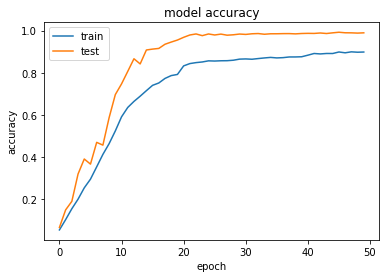

In [19]:
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save model

In [11]:
model_name = "TSR_Model_98acc50Epoch_MACM1"

In [21]:
model.save(f'./MODELS/{model_name}')

2022-01-03 15:03:31.001660: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MODELS/TSR_Model_96perEpoch35_MACM1/assets


In [12]:
model = models.load_model(f'./MODELS/{model_name}')
model.compile(
    optimizer = optimizer, 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy"]
)

2022-01-19 15:51:15.325048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-19 15:51:15.325115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Prediction

In [22]:
signDict = {}

for i in range(len(Ytrain)):
    
    classs = np.argmax(Ytrain[i])
    
    if classs not in signDict.keys():
        signDict[classs] = i

print(signDict)

{2: 0, 31: 1, 5: 2, 11: 3, 4: 4, 13: 5, 18: 7, 10: 8, 25: 11, 24: 13, 8: 16, 16: 17, 9: 18, 35: 20, 38: 21, 12: 22, 19: 25, 37: 28, 1: 29, 7: 31, 34: 35, 14: 38, 39: 39, 33: 41, 3: 42, 6: 43, 36: 46, 17: 58, 15: 69, 29: 74, 22: 103, 28: 112, 27: 123, 20: 131, 23: 155, 0: 169, 41: 191, 30: 195, 26: 215, 32: 286, 21: 335, 42: 399, 40: 544}


In [40]:
imagePredictionSRC = os.path.join(data_path, "val/3.jpg")

### Load image 

In [41]:
image = cv2.imread(imagePredictionSRC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [42]:
image_rs = cv2.resize(image, (img_size, img_size), 3)        

R, G, B = cv2.split(image_rs)     

img_r = cv2.equalizeHist(R)
img_g = cv2.equalizeHist(G)
img_b = cv2.equalizeHist(B)        

image = cv2.merge((img_r, img_g, img_b))

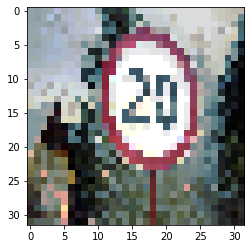

In [43]:
plt.imshow(image)

### Predict image

In [44]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255. 

In [45]:
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)[0]

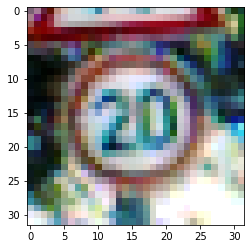

In [46]:
plt.imshow(Xtrain[signDict[predicted_class]])